# DATA PREPARATION

## Memuat Data Awal & Inspeksi

In [24]:
import pandas as pd

# Initial Data Load and Inspection
file_name = "dataset_prediksi_cuaca.csv"
# Baca data, simpan di df, dan juga simpan df_tanggal untuk urutan kolom akhir
df = pd.read_csv(file_name) 
df_tanggal = df[['Tanggal']].copy()

print("--- 5 Baris Awal ---")
print(df.head())
print("\n--- Informasi Data ---")
df.info()

--- 5 Baris Awal ---
      Tanggal   Lokasi  Suhu Maks (deg of C)  Suhu Min (deg of C)  \
0  2019-01-01  Jakarta                  32.7                 27.4   
1  2019-01-02  Jakarta                  30.4                 25.3   
2  2019-01-03  Jakarta                  26.9                 21.3   
3  2019-01-04  Jakarta                  30.1                 26.1   
4  2019-01-05  Jakarta                  30.6                 25.9   

   Kelembaban (%)  Kecepatan Angin (km/jam)  Arah Angin (deg)  \
0              72                       7.3             311.7   
1              83                      11.5             288.8   
2              61                      11.2             183.6   
3              83                      12.3              99.8   
4              76                      13.7             350.8   

   Tekanan Udara (hPa)  Tutupan Awan (%)  Curah Hujan Hari Ini (mm)  \
0               1010.6                85                        6.2   
1               1011.0         

## Pembersihan Data & Penyederhanaan Kolom

In [25]:
# Data Cleaning and Feature Engineering (Cleaning)

# Ubah nama kolom agar mudah digunakan di Python
df.columns = [
    'Tanggal', 'Lokasi', 'Suhu_Maks_C', 'Suhu_Min_C', 'Kelembaban_persen',
    'Kecepatan_Angin_kmh', 'Arah_Angin_deg', 'Tekanan_Udara_hPa',
    'Tutupan_Awan_persen', 'Curah_Hujan_Hari_Ini_mm', 'Cuaca_Hari_Ini',
    'Curah_Hujan_Besok_mm', 'Cuaca_Besok'
]

# Drop kolom yang tidak digunakan: Lokasi dan Tanggal (karena Tanggal sudah diamankan di df_tanggal)
df = df.drop(columns=['Lokasi', 'Tanggal'])

print("--- 5 Baris Awal Setelah Cleaning ---")
print(df.head())

--- 5 Baris Awal Setelah Cleaning ---
   Suhu_Maks_C  Suhu_Min_C  Kelembaban_persen  Kecepatan_Angin_kmh  \
0         32.7        27.4                 72                  7.3   
1         30.4        25.3                 83                 11.5   
2         26.9        21.3                 61                 11.2   
3         30.1        26.1                 83                 12.3   
4         30.6        25.9                 76                 13.7   

   Arah_Angin_deg  Tekanan_Udara_hPa  Tutupan_Awan_persen  \
0           311.7             1010.6                   85   
1           288.8             1011.0                   47   
2           183.6             1004.2                   87   
3            99.8             1002.3                   55   
4           350.8             1021.1                   63   

   Curah_Hujan_Hari_Ini_mm Cuaca_Hari_Ini  Curah_Hujan_Besok_mm    Cuaca_Besok  
0                      6.2   Hujan Ringan                   0.0  Cerah Berawan  
1           

## Pembuatan Variabel Target (Y) - Waktu & Volume Siram

In [26]:
# Feature Engineering (Waktu Siram & Volume - Target Variables)

# Fungsi untuk menentukan volume dan waktu siram
def tentukan_siraman(row):
    curah_besok = row['Curah_Hujan_Besok_mm']
    kelembaban_hari_ini = row['Kelembaban_persen']
    suhu_maks = row['Suhu_Maks_C']

    # Logika 1 & 2: Tidak Perlu Siram
    if curah_besok > 10 or (curah_besok <= 10 and kelembaban_hari_ini > 80):
        volume = 0.0
        waktu = 'Tidak Perlu Siram'
        return pd.Series([volume, waktu])

    # Logika 3: Perlu Siram
    else:
        # Hitung Volume (maks 15L, dikurangi 0.5L per mm hujan besok, min 1L)
        volume = max(1.0, 15 - (curah_besok * 0.5))

        # Tentukan Waktu Siram
        if suhu_maks > 30:
            waktu = 'Pagi_06-09'
        else:
            waktu = 'Sore_16-18'

        return pd.Series([volume, waktu])

# Terapkan fungsi untuk membuat kolom target
df[['volume_air_estimasi_liter', 'waktu_siram_estimasi']] = df.apply(tentukan_siraman, axis=1)

# Tambahan: Buat kolom target biner 'perlu_siram_besok'
# Jika volume > 0, maka perlu siram (1), jika 0, maka tidak perlu siram (0)
df['perlu_siram_besok'] = (df['volume_air_estimasi_liter'] > 0).astype(int)

print("--- Distribusi Target Waktu Siram ---")
print(df['waktu_siram_estimasi'].value_counts(normalize=True))
print("\n--- Distribusi Target Perlu Siram (Biner) ---")
print(df['perlu_siram_besok'].value_counts(normalize=True))

--- Distribusi Target Waktu Siram ---
waktu_siram_estimasi
Pagi_06-09           0.492013
Tidak Perlu Siram    0.381105
Sore_16-18           0.126883
Name: proportion, dtype: float64

--- Distribusi Target Perlu Siram (Biner) ---
perlu_siram_besok
1    0.618895
0    0.381105
Name: proportion, dtype: float64


## Pembuatan Fitur Moving Average (MA)

In [27]:
# Feature Engineering (Moving Average)

# Hitung Moving Average (MA) 3 Hari (Window=3) untuk 3 fitur utama
df['MA3_Suhu_Maks_C'] = df['Suhu_Maks_C'].rolling(window=3).mean()
df['MA3_Kelembaban_persen'] = df['Kelembaban_persen'].rolling(window=3).mean()
df['MA3_Curah_Hujan_mm'] = df['Curah_Hujan_Hari_Ini_mm'].rolling(window=3).mean()

# Hapus 2 baris teratas yang memiliki nilai NaN (karena MA 3 hari belum bisa dihitung)
df = df.dropna()
# Sesuaikan df_tanggal agar barisnya sinkron dengan df yang sudah di dropna
df_tanggal = df_tanggal.iloc[df.index]


print(f"Jumlah Baris Data Akhir: {len(df)}")

Jumlah Baris Data Akhir: 2189


## One-Hot Encoding untuk Kategorikal

In [28]:
# Data Encoding (One-Hot Encoding)
df_encoded = pd.get_dummies(df, columns=['Cuaca_Hari_Ini'], drop_first=True, dtype=int)

# Hapus kolom 'Curah_Hujan_Besok_mm' dan 'Cuaca_Besok' karena tidak diminta di 19 kolom akhir, 
# dan 'Curah_Hujan_Besok_mm' berpotensi menyebabkan data leakage jika digunakan di model.
df_encoded = df_encoded.drop(columns=['Curah_Hujan_Besok_mm', 'Cuaca_Besok'])

# Gabungkan kembali kolom 'Tanggal' yang sudah disinkronkan dari BLOCK 4
df_encoded = pd.concat([df_tanggal.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)


# --- Pengurutan Kolom Sesuai Permintaan (19 Kolom) ---
df_encoded.columns = df_encoded.columns.str.replace(r'Cuaca_Hari_Ini_', 'cuaca_hari_', regex=True)

# Tentukan urutan kolom final (19 KOLOM)
final_order = [
    'Tanggal', # 1. tanggal (menggunakan nama asli 'Tanggal')
    'Suhu_Maks_C', # 2. suhu_maks_deg_of_c (nama aslinya 'Suhu_Maks_C')
    'Suhu_Min_C', # 3. suhu_min_deg_of_c (nama aslinya 'Suhu_Min_C')
    'Kelembaban_persen', # 4. kelembaban (nama aslinya 'Kelembaban_persen')
    'Kecepatan_Angin_kmh', # 5. kecepatan_angin_kmjam (nama aslinya 'Kecepatan_Angin_kmh')
    'Arah_Angin_deg', # 6. arah_angin_deg
    'Tekanan_Udara_hPa', # 7. tekanan_udara_hpa
    'Tutupan_Awan_persen', # 8. tutupan_awan (nama aslinya 'Tutupan_Awan_persen')
    'Curah_Hujan_Hari_Ini_mm', # 9. curah_hujan_hari_ini_mm

    # Kolom OHE yang DIBUAT (menggunakan nama baru cuaca_hari_*)
    'cuaca_hari_Cerah Berawan', # 10. cuaca_hari_Cerah Berawan
    'cuaca_hari_Hujan Lebat',   # 11. cuaca_hari_Hujan Lebat
    'cuaca_hari_Hujan Ringan',  # 12. cuaca_hari_Hujan Ringan
    'cuaca_hari_Hujan Sedang',  # 13. cuaca_hari_Hujan Sedang
    
    'perlu_siram_besok', # 14. perlu_siram_besok (Target Biner)

    # Kolom MA
    'MA3_Suhu_Maks_C', # 15. ma_3_hari_suhu_maksdeg_of_c (nama aslinya 'MA3_Suhu_Maks_C')
    'MA3_Kelembaban_persen', # 16. ma_3_hari_kelembaban (nama aslinya 'MA3_Kelembaban_persen')
    'MA3_Curah_Hujan_mm', # 17. ma_3_hari_kecepatan_angin_kmjam (nama aslinya 'MA3_Curah_Hujan_mm', ada kesalahan penamaan di permintaan, tapi saya pakai nama MA3 yang dihitung)
    
    # Kolom Target
    'volume_air_estimasi_liter', # 18. volume_air_estimasi_liter
    'waktu_siram_estimasi', # 19. waktu_siram_estimasi
]

# Ambil hanya 19 kolom yang diminta
df_final = df_encoded[final_order].copy()


print("--- Kolom Setelah Encoding dan Pengurutan ---")
print(df_final.columns.tolist())
print(f"Total Kolom: {len(df_final.columns)}")

--- Kolom Setelah Encoding dan Pengurutan ---
['Tanggal', 'Suhu_Maks_C', 'Suhu_Min_C', 'Kelembaban_persen', 'Kecepatan_Angin_kmh', 'Arah_Angin_deg', 'Tekanan_Udara_hPa', 'Tutupan_Awan_persen', 'Curah_Hujan_Hari_Ini_mm', 'cuaca_hari_Cerah Berawan', 'cuaca_hari_Hujan Lebat', 'cuaca_hari_Hujan Ringan', 'cuaca_hari_Hujan Sedang', 'perlu_siram_besok', 'MA3_Suhu_Maks_C', 'MA3_Kelembaban_persen', 'MA3_Curah_Hujan_mm', 'volume_air_estimasi_liter', 'waktu_siram_estimasi']
Total Kolom: 19


## Final Split & Scaling (Klasifikasi Waktu Siram)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Final Data Preparation: Defining X and Y, dan Classification Split

# 1. Tentukan Variabel Target (Y)
y_class = df_final['waktu_siram_estimasi']

# 2. Tentukan Variabel Fitur (X)
# Drop kolom target dan kolom yang tidak digunakan untuk modeling
X = df_final.drop(columns=[
    'Tanggal', # Tidak boleh diskala
    'waktu_siram_estimasi',
    'volume_air_estimasi_liter',
    'perlu_siram_besok'
])

# 3. Scaling/Normalisasi (PENTING untuk SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


# 4. Pembagian Data (Train-Test Split) untuk CLASSIFICATION (Waktu Siram)
# Catatan: Stratify pada y_class
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_scaled_df, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"X_train_class: {X_train_class.shape}")
print(f"Distribusi Target Training:\n{y_train_class.value_counts(normalize=True)}")

X_train_class: (1751, 15)
Distribusi Target Training:
waktu_siram_estimasi
Pagi_06-09           0.492290
Tidak Perlu Siram    0.380925
Sore_16-18           0.126785
Name: proportion, dtype: float64


In [30]:
# Menyimpan DataFrame setelah preparation, encoding, dan pengurutan ke dalam file CSV

csv_file_name = 'dataset_setelah_preparation_19_kolom.csv'
df_final.to_csv(csv_file_name, index=False)

print(f"DataFrame berhasil disimpan ke dalam file: {csv_file_name}")

# Menampilkan 5 baris pertama untuk konfirmasi urutan kolom
print("\n--- 5 Baris Data Akhir (Konfirmasi Urutan Kolom) ---")
print(df_final.head().to_string())
print("\n--- Informasi Tipe Data Akhir ---")
df_final.info()

DataFrame berhasil disimpan ke dalam file: dataset_setelah_preparation_19_kolom.csv

--- 5 Baris Data Akhir (Konfirmasi Urutan Kolom) ---
      Tanggal  Suhu_Maks_C  Suhu_Min_C  Kelembaban_persen  Kecepatan_Angin_kmh  Arah_Angin_deg  Tekanan_Udara_hPa  Tutupan_Awan_persen  Curah_Hujan_Hari_Ini_mm  cuaca_hari_Cerah Berawan  cuaca_hari_Hujan Lebat  cuaca_hari_Hujan Ringan  cuaca_hari_Hujan Sedang  perlu_siram_besok  MA3_Suhu_Maks_C  MA3_Kelembaban_persen  MA3_Curah_Hujan_mm  volume_air_estimasi_liter waktu_siram_estimasi
0  2019-01-03         26.9        21.3                 61                 11.2           183.6             1004.2                   87                      8.4                         0                       0                        1                        0                  1        30.000000              72.000000            4.866667                      13.75           Sore_16-18
1  2019-01-04         30.1        26.1                 83                 12.3          

# MODELING

## Pelatihan Support Vector Classifier (SVC)

In [31]:
from sklearn.svm import SVC

# Modeling - Support Vector Classifier (SVC) Training

# Inisialisasi Model SVC dengan weight seimbang untuk mengatasi ketidakseimbangan kelas
model_svc = SVC(kernel='rbf', random_state=42, class_weight='balanced')

# Latih Model
# Catatan: X_train_class dan y_train_class berasal dari Data Preparation Block 6
model_svc.fit(X_train_class, y_train_class)

print("--- Pelatihan Model SVC Selesai ---")

--- Pelatihan Model SVC Selesai ---


## Pembagian Data Regresi (Volume Air)

In [32]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Train-Test Split for Regression

# Tentukan Target Regresi (REVISI: menggunakan df_final)
# Target di sini tidak boleh di-stratify karena ini adalah regresi
y_reg = df_final['volume_air_estimasi_liter']

# Pembagian Data (Train-Test Split) untuk REGRESSION (Volume Air)
# Menggunakan X_scaled_df yang sama dengan klasifikasi
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled_df, y_reg, test_size=0.2, random_state=42
)

print(f"X_train_reg: {X_train_reg.shape}")
print(f"y_test_reg: {y_test_reg.shape}")

X_train_reg: (1751, 15)
y_test_reg: (438,)


## Pelatihan Support Vector Regressor (SVR)

In [33]:
from sklearn.svm import SVR
import numpy as np # Tambahkan import numpy jika belum ada

# Modeling - Support Vector Regressor (SVR) Training

# Inisialisasi Model SVR
model_svr = SVR(kernel='rbf')

# Latih Model
# Menggunakan .ravel() untuk menghindari FutureWarning pada SVR
model_svr.fit(X_train_reg, y_train_reg.ravel())

print("--- Pelatihan Model SVR Selesai ---")

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_23564\3806984095.py:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_svr.fit(X_train_reg, y_train_reg.ravel())


--- Pelatihan Model SVR Selesai ---


# EVALUATION

## Evaluasi SVC (Waktu Siram)

--- Laporan Klasifikasi (Classification Report) ---
                   precision    recall  f1-score   support

       Pagi_06-09       0.94      0.87      0.90       215
       Sore_16-18       0.63      0.96      0.76        56
Tidak Perlu Siram       0.87      0.80      0.83       167

         accuracy                           0.85       438
        macro avg       0.81      0.88      0.83       438
     weighted avg       0.87      0.85      0.86       438



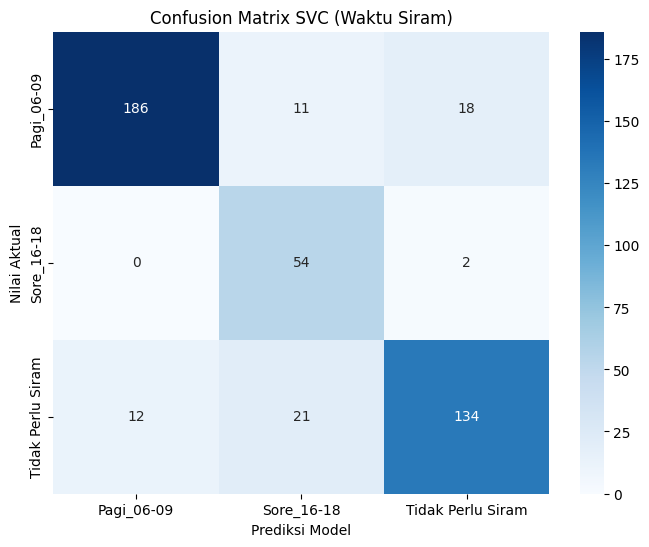

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation - SVC (Klasifikasi Waktu Siram)

# 1. Prediksi pada Data Testing
y_pred_class = model_svc.predict(X_test_class)

# 2. Classification Report
print("--- Laporan Klasifikasi (Classification Report) ---")
print(classification_report(y_test_class, y_pred_class))

# 3. Confusion Matrix (Visualisasi) 
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_svc.classes_, yticklabels=model_svc.classes_)
plt.title('Confusion Matrix SVC (Waktu Siram)')
plt.ylabel('Nilai Aktual')
plt.xlabel('Prediksi Model')
plt.savefig('confusion_matrix_svc_waktu_siram.png')
plt.show() # Tampilkan Confusion Matrix

## Evaluasi SVR (Volume Air)

--- Hasil Evaluasi SVR (Volume Air) ---
Root Mean Squared Error (RMSE): 5.0643 liter
R-squared (R^2): 0.4673


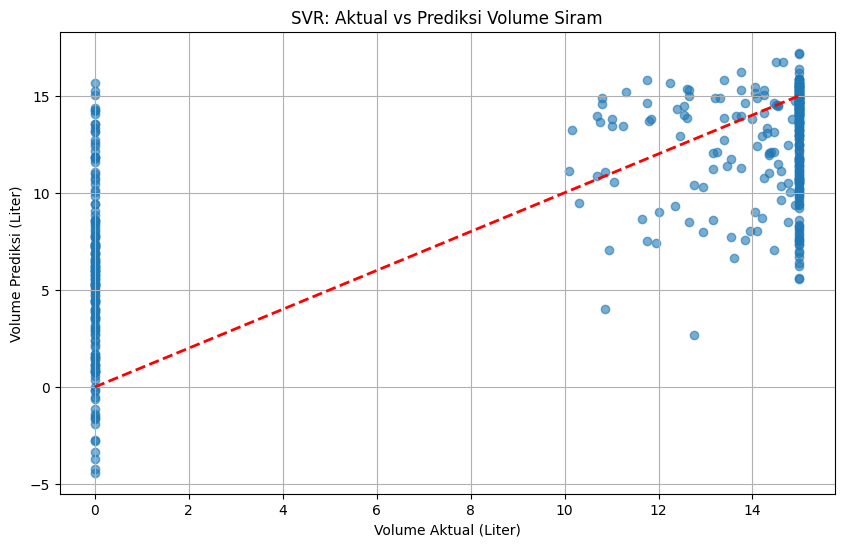

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Evaluation - SVR (Regresi Volume Air)

# 1. Prediksi pada Data Testing
y_pred_reg = model_svr.predict(X_test_reg)

# 2. Hitung Metrik Regresi
mse = mean_squared_error(y_test_reg, y_pred_reg)
# RMSE menunjukkan rata-rata besar error prediksi dalam satuan liter
rmse = np.sqrt(mse) 
# R^2 menunjukkan proporsi varians dalam variabel dependen yang dapat diprediksi dari variabel independen
r2 = r2_score(y_test_reg, y_pred_reg) 

print("--- Hasil Evaluasi SVR (Volume Air) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} liter")
print(f"R-squared (R^2): {r2:.4f}")

# 3. Visualisasi Aktual vs Prediksi 
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
# Garis ideal (y=x)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title('SVR: Aktual vs Prediksi Volume Siram')
plt.xlabel('Volume Aktual (Liter)')
plt.ylabel('Volume Prediksi (Liter)')
plt.grid(True)
plt.savefig('svr_aktual_vs_prediksi_volume.png')
plt.show() # Tampilkan Scatter Plot